In [1]:
from astropy.io import fits
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.vq import vq, kmeans
import scipy
from astroquery.gaia import Gaia
import os

import match

Text(0.5, 1.0, 'DES and Gaia Match Completeness (i-band)')

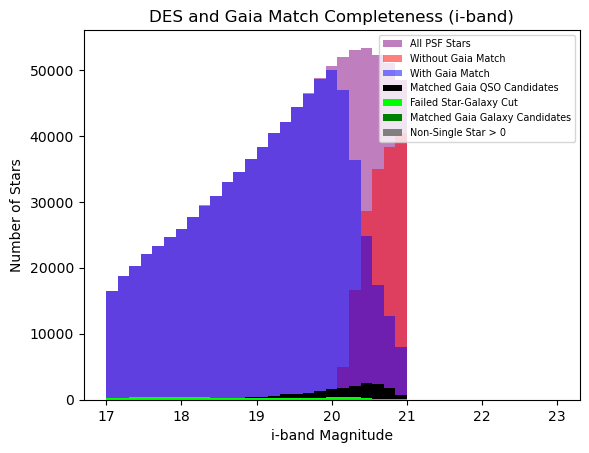

In [3]:
RESULTS_FILEPATH = "../results/"
RESULTS_FILEPATH_BAND = "../results/iband/"
BAND = 'i'
master_comb_df = pd.read_csv(RESULTS_FILEPATH_BAND + "DES_MATCH_BANDi.csv")
match.plot_match_completeness(master_comb_df, fold = RESULTS_FILEPATH_BAND, BAND = BAND, bounds = [17, 23])
plt.title("DES and Gaia Match Completeness (i-band)")

In [31]:
from astropy.io.votable import from_table, writeto
from astropy.table import Table

# Select the columns for Gaia RA and Dec
gaia_coords_df = master_comb_df[['gaia_ra', 'gaia_dec']]

# Convert the DataFrame to an Astropy Table
gaia_coords_table = Table.from_pandas(gaia_coords_df)

# Convert the Table to a VOTable
votable = from_table(gaia_coords_table)

# Save the VOTable as an XML file
votable_filepath = "gaia_coords_of_des.xml"
writeto(votable, votable_filepath)

print(f"VOTable saved to {votable_filepath}")

VOTable saved to gaia_coords_of_des.xml


In [ ]:
# In the end, this was the query
# SELECT gaia.ra, gaia.dec, des.*
# FROM user_sagarwal.table1 AS des
# JOIN gaiadr3.gaia_source AS gaia ON 
# DISTANCE(des.gaia_ra, des.gaia_dec, gaia.ra, gaia.dec) < 0.00028

from astropy.io.votable import parse

# Parse the VOTable file
votable = parse("gaia_server_des_match.vot")

# Convert the first table in the VOTable to an Astropy Table
table = votable.get_first_table().to_table()

# Convert the Astropy Table to a pandas DataFrame
gaia_server_des_match_df = table.to_pandas()

print(gaia_server_des_match_df.head())

           ra        dec  astrometric_excess_noise  phot_g_mean_mag  \
0  314.094061 -64.284224                  3.319962        21.174145   
1  314.223159 -64.456143                  0.000000        19.095055   
2  315.600549 -64.293845                  0.097784        18.738873   
3  315.453591 -64.642682                  0.000000        18.637028   
4  315.074415 -61.354800                  0.000000        18.580177   

   phot_bp_mean_mag  phot_rp_mean_mag  des_oid     gaia_ra   gaia_dec  
0         20.634293         19.887693        1  314.094061 -64.284224  
1         20.296333         18.038639        2  314.223159 -64.456143  
2         20.060926         17.600863        3  315.600549 -64.293845  
3         19.343134         17.812775        4  315.453591 -64.642682  
4         19.162750         17.960045        5  315.074415 -61.354800  


In [34]:
des = gaia_server_des_match_df
des_merged = des.merge(master_comb_df, left_on=['ra', 'dec'], right_on=['gaia_ra', 'gaia_dec'], suffixes=('_des', '_master'))
#Separator: gaia_table["is_star"] = (np.log10(np.maximum(gaia_table['astrometric_excess_noise'], 1e-12)) < np.maximum((gaia_table['phot_g_mean_mag']-18.2)*.3+.2,.3))


(0.0, 2.0)

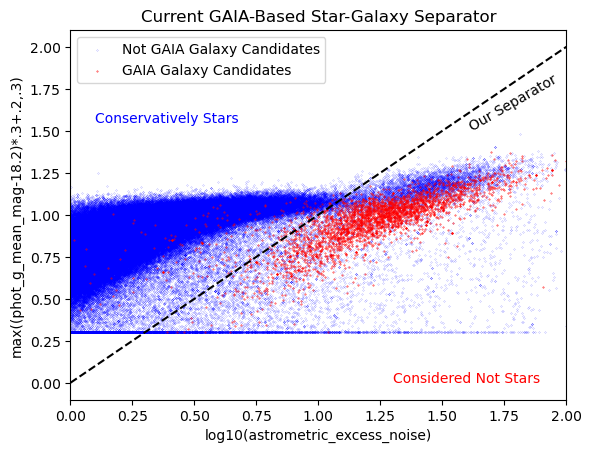

In [78]:
# Plot stars
stars = des_merged[des_merged['in_galaxy_candidates'] == False]
plt.scatter(np.log10(np.maximum(stars['astrometric_excess_noise'], 1e-12)), 
            np.maximum((stars['phot_g_mean_mag']-18.2)*.3+.2,.3), s = 0.01, c = 'blue', label='Not GAIA Galaxy Candidates')

# Plot galaxies
galaxies = des_merged[des_merged['in_galaxy_candidates'] == True]
plt.scatter(np.log10(np.maximum(galaxies['astrometric_excess_noise'], 1e-12)), 
            np.maximum((galaxies['phot_g_mean_mag']-18.2)*.3+.2,.3), s = 0.11, c = 'red', label='GAIA Galaxy Candidates')

# Add text annotations
plt.text(1.6, 1.5, "Our Separator", color='k', rotation=30)
plt.text(0.1, 1.55, "Conservatively Stars", color='blue')
plt.text(1.3, 0, "Considered Not Stars", color='red')

plt.legend()
plt.plot([0, 2], [0, 2], 'k--')
plt.title("Current GAIA-Based Star-Galaxy Separator")
plt.xlabel("log10(astrometric_excess_noise)")
plt.ylabel("max((phot_g_mean_mag-18.2)*.3+.2,.3)")
plt.xlim(0, 2)

In [ ]:


# Convert the list of tables to a single DataFrame
gaia_df = pd.concat([r.to_pandas() for r in gaia_data], ignore_index=True)

# Match the stars based on ra and dec
idx, d2d, d3d = coords.match_to_catalog_sky(SkyCoord(ra=gaia_df['ra']*u.degree, dec=gaia_df['dec']*u.degree))

# Add the matched Gaia data to the master_comb_df
master_comb_df['gaia_source_id'] = gaia_df.iloc[idx]['source_id'].values
master_comb_df['gaia_ra_matched'] = gaia_df.iloc[idx]['ra'].values
master_comb_df['gaia_dec_matched'] = gaia_df.iloc[idx]['dec'].values
master_comb_df['gaia_parallax'] = gaia_df.iloc[idx]['parallax'].values
master_comb_df['gaia_pmra'] = gaia_df.iloc[idx]['pmra'].values
master_comb_df['gaia_pmdec'] = gaia_df.iloc[idx]['pmdec'].values

print(master_comb_df.head())